In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import re


def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
########## Fire incidents ############
incidents_attr_2012= pd.read_csv('fire_2012.csv',encoding="ISO-8859-1")
incidents_attr_2012['YEAR']='2012'

incidents_attr_2013= pd.read_csv('fire_2013.csv',encoding="ISO-8859-1")
incidents_attr_2013['YEAR']='2013'

incidents_attr_2014= pd.read_csv('fire_2014.csv',encoding="ISO-8859-1")
incidents_attr_2014['YEAR']='2014'

incidents_attr_2015= pd.read_csv('fire_2015.csv',encoding="ISO-8859-1")
incidents_attr_2015['YEAR']='2015'

incidents_attr_2016= pd.read_csv('fire_2016.csv',encoding="ISO-8859-1")
incidents_attr_2016['YEAR']='2016'

incidents_attr_mar2017= pd.read_csv('fire_mar2017.csv',encoding="ISO-8859-1")
incidents_attr_mar2017['YEAR']='2017'

incidents_attr_feb2017= pd.read_csv('fire_feb2017.csv',encoding="ISO-8859-1")
incidents_attr_feb2017['YEAR']='2017'

incidents_attr_jan2017= pd.read_csv('fire_jan2017.csv',encoding="ISO-8859-1")
incidents_attr_jan2017['YEAR']='2017'

incidents_attr_all = pd.concat([incidents_attr_2012,incidents_attr_2013,incidents_attr_2014,incidents_attr_2015,incidents_attr_2016,incidents_attr_jan2017])

/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# ########## Fire incidents and Property Types Codebook ############

# ## Create a codebook for all incident types
# # incidents = incidents.drop(['Exposure Number','Address 2','xStreet Prefix','xStreet Name','xStreet Type','xStreet Suffix','State','Country','Address','Street Number','Street Prefix','Street Name','Street Type','Street Suffix'], 1)
# incident_types = incidents[['Incident Type','Incident Description']].sort_values(by='Incident Type').drop_duplicates().reset_index(drop=True)
# incident_types.to_csv('incident_codebook.csv')
# incident_types.head()



# ## Create a codebook for all property types
# property_types = incidents[['Property Use','Property Description']].sort_values(by='Property Use').drop_duplicates().reset_index(drop=True)
# property_types.to_csv('property_codebook.csv')
# property_types.head()

In [5]:
########## Incidents of Interest ############

##########################################################################
## Incidents of interest | Fires ##
# 100 Fire,other
# 111 Building Fire
# 113 Cooking fire, confined to container
# 116 Fuel burner/boiler malfunction, fire confined
### 118 Trash or rubbish fire, contained
### 140, 142, 150, 151, 154 155, 160, 162 = Outdoor fires
###########################################################################

##########################################################################
## Incidents of interest | Leakages ##
# 400 Hazardous condition, Other
# 410 Combustible/flammable gas/liquid condition, other
# 411 Gasoline or other flammable liquid spill
# 412 Gas leak (natural gas or LPG)
# 413 Oil or other combustible liquid spill
# 421 Chemical hazard (no spill or leak)
# 422 Chemical spill or leak
# 423 Refrigeration leak
# 424 Carbon monoxide incident
# 440 Electrical wiring/equipment problem, Other
# 441 Heat from short circuit (wiring), defective/worn
###########################################################################

########## Properties of NO Interest (All type without built structures) ############
##########################################################################
# 900	Outside or special property, Other
# 919	Dump, sanitary landfill
# 921	Bridge, trestle
# 922	Tunnel
# 931	Open land or field
# 936	Vacant lot
# 938	Graded and cared-for plots of land
# 940	Water area, Other
# 941	Open ocean, sea or tidal waters
# 951	Railroad right-of-way
# 952	Railroad yard
# 960	Street, Other
# 961	Highway or divided highway
# 962	Residential street, road or residential driveway
# 963	Street or road in commercial area
# 965	Vehicle parking area
# 973	Aircraft taxiway
# 981	Construction site
# 983	Pipeline, power line or other utility right-of-way
###########################################################################

In [8]:
### Filter for good zip codes
incidents_attr_all['Zip_filter'] =np.where(incidents_attr_all['Zip'].apply(lambda x: str(x).isdigit())==True, 1, 0)
incidents_attr_all=incidents_attr_all[incidents_attr_all['Zip_filter']==1]
incidents_attr_all= incidents_attr_all[incidents_attr_all['Zip']!='099999']

## Now extract the incidents that we want to predict and categorize them
# incidents_keep = incidents_attr_all[incidents_attr_all['Incident Type'].isin(['100', '111','113','116','118','140','142','150','151','154','155','160',\
#                                           '400','410','412','413','422','423','424','440','441'])]
incidents_keep = incidents_attr_all[incidents_attr_all['Incident Type'].isin(['100', '111','113','116'])]


# mask = np.logical_not(incidents_keep['Property Use'].isin(['900','919','921','922','931','936','938','940','941','951','952','960','961','962',\
#                                                      '963','965','973','981','983','NNN' ,'UUU ']))
# incidents_keep = incidents_keep[mask]
incidents_keep['cat1']=np.where(incidents_keep['Incident Type'].astype(str).str[0]=='1', 'fire', 'leak')

incidents_keep['Zip']=incidents_keep['Zip'].astype(float)
incidents_keep['Street Suffix'].replace(['AV  '], ['AVE  '], inplace=True)
incidents_keep['Street Number']=incidents_keep['Street Number'].astype(str)
incidents_keep['Street Name'] =incidents_keep['Street Name'].str.strip()
# incidents_keep['parcel_num']=np.nan


incidents_keep['streetname_new']=incidents_keep.apply(lambda x:'%s %s %s' % (x['Street Prefix'],x['Street Name'],x['Street Suffix']),axis=1)
incidents_keep['streetname_new']=incidents_keep['streetname_new'].str.lower()
incidents_keep['streetname_new']=incidents_keep['streetname_new'].str.strip()



########### Geocoding ####################
## Use Master Address List to Geocode bulk of the addresses
alladdress = pd.read_csv('Master_Address_List.csv').groupby('parcel_num').first().reset_index()
alladdress=alladdress.rename(columns={'p_streetnumber':'Street Number','p_streetname':'streetname_new','p_zipcode':'Zip'}) 
alladdress= alladdress.drop(['fire_district','pwd_district','city_council_district','police_district','neighborhood','neighborhood_services_district','ward','precinct','land_usage','trash_day','recycling_day'],1)
alladdress['streetname_new']=alladdress['streetname_new'].str.lower()


incidents_addrjoin = incidents_keep.merge(alladdress, how='left', left_on=['streetname_new','Zip','Street Number'], \
                                     right_on=['streetname_new','Zip','Street Number'])
incidents_addrjoin['geocode_method']= np.where(incidents_addrjoin['Latitude'].isnull()==False, 'master_addr', 'else')
incidents_addrjoin = incidents_addrjoin.groupby('Incident Number').first().reset_index()

# incidents_addrjoin.crs = {'init' :'epsg:4326'}

/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [9]:
incidents_addrjoin_leftover = incidents_addrjoin[incidents_addrjoin['parcel_num'].isnull()==True]

## Join incidents to master address list by implementing a pseudo-fuzzy adddress matching
for index,row in incidents_addrjoin_leftover.iterrows():
    possible_address = alladdress[(alladdress['streetname_new']== row['streetname_new']) & \
                                  (alladdress['Zip'] ==row['Zip'])] 
    for a_index, a_row in possible_address.iterrows():
        if '-' in a_row['Street Number']:
            start, end = a_row['Street Number'].split('-')
            try: 
                if float(re.sub("[^0-9]", "", start)) <= float(row['Street Number']) <= float(re.sub("[^0-9]", "", end)):
                    incidents_addrjoin.ix[index,'parcel_num']=a_row['parcel_num']
                else:
                    pass
            except ValueError:
                pass
        else: 
            try:
                if float(re.sub("[^0-9]", "", row['Street Number'])) == float(re.sub("[^0-9]", "", a_row['Street Number'])): 
                    incidents_addrjoin.ix[index,'parcel_num']=a_row['parcel_num']
            except ValueError: 
                pass




In [10]:
## Convert date to pandas datetime
incidents_addrjoin['Alarm Date']=pd.to_datetime(incidents_addrjoin['Alarm Date'])


In [ ]:
### There are still quite a few un-geocoded incidents, which there is the option to join using something like a join 
### by street layer or a join by google maps API
# unjoined = incidents_addrjoin[incidents_addrjoin['parcel_num'].isnull()==True]
# unjoined['Zip']=unjoined['Zip'].map(lambda x: "0"+str(int(x)))
# unjoined.ix[:2000,:].to_csv('unjoined1.csv')
# unjoined.ix[2001:4000,:].to_csv('unjoined2.csv')
# unjoined.ix[4001:6000,:].to_csv('unjoined3.csv')
# unjoined.ix[6001:8000,:].to_csv('unjoined4.csv')
# unjoined.ix[8001:10000,:].to_csv('unjoined5.csv')
# unjoined.ix[10001:,:].to_csv('unjoined6.csv')

In [11]:
########## Parcels ############

parcels = gpd.read_file('Parcels_2016_Data_Full.shp')
## As many of the parcels overlap each other, we just take the first of each parcel
parcels.crs = {'init' :'epsg:4326'}
parcels.head()


## Clean the parcel data a little

## Parcels that contain either commercial or residential built up areas
parcels=parcels.query("GROSS_AREA >10 and LIVING_ARE>10")


## Buildings that have wrong year builts.  
parcels = parcels[parcels['YR_BUILT'].astype(float)>1000]
                  
## As many of the parcels overlap each other, we just take the first of each parcel
parcels =parcels.rename(columns={'objectid': 'OBJECTID'}).groupby('PID_LONG').first().reset_index()


parcels.crs = {'init' :'epsg:4326'}



In [12]:
###### Join incidents to parcels ######
## Turn all the parcel numbers in to floats
parcels['PID_LONG_flt']=parcels['PID_LONG'].astype(float)
incidents_addrjoin['parcel_num_flt']=incidents_addrjoin['parcel_num'].astype(float)
# parcels_incidents = parcels.merge(incidents_addrjoin, left_on='PID_LONG_flt',right_on='parcel_num_flt',how="left")

In [13]:
parcels.columns

Index(['PID_LONG', 'AV_BLDG', 'AV_LAND', 'AV_TOTAL', 'CM_ID', 'EGIS_WM_db',
       'FULL_ADDRE', 'GIS_ID', 'GROSS_AREA', 'GROSS_TAX', 'LAND_SF',
       'LIVING_ARE', 'LU', 'MAIL_ADDRE', 'MAIL_ADD_1', 'MAIL_CS', 'MAIL_ZIPCO',
       'NUM_FLOORS', 'OBJECTID', 'OWNER', 'OWN_OCC', 'PID', 'PTYPE', 'R_AC',
       'R_BDRMS', 'R_BLDG_STY', 'R_EXT_FIN', 'R_FPLACE', 'R_FULL_BTH',
       'R_HALF_BTH', 'R_HRAT_TYP', 'R_KITCH', 'R_ROOF_TYP', 'R_TOTAL_RM',
       'SHAPESTAre', 'SHAPESTLen', 'STRUCTURE_', 'ST_NAME', 'ST_NAME_SU',
       'ST_NUM', 'S_BLDG_STY', 'S_EXT_FIN', 'S_NUM_BLDG', 'S_UNIT_COM',
       'S_UNIT_RC', 'S_UNIT_RES', 'UNIT_NUM', 'U_AC', 'U_BASE_FLO', 'U_BDRMS',
       'U_CORNER', 'U_FPLACE', 'U_FULL_BTH', 'U_HALF_BTH', 'U_HEAT_TYP',
       'U_KIT_TYPE', 'U_NUM_PARK', 'U_ORIENT', 'U_TOT_RMS', 'YEAR', 'YR_BUILT',
       'YR_REMOD', 'ZIPCODE', 'geometry', 'PID_LONG_flt'],
      dtype='object')

In [14]:
########## Violations ############
violations = gpd.read_file('cepviolations.shp')
violations= violations.drop(['StNo','StHigh','Street','Suffix','State','Location'],1)

violations['Year']=violations['Status_DTT'].astype(str).str[:4]


In [16]:
########## Violations Code book ############
# violation_types = violations[['Code','Description']].drop_duplicates().reset_index(drop=True)
# violation_types.to_csv('violation_codebook.csv')

In [15]:
violations.head()

,City,Code,Descriptio,Latitude,Longitude,Property_I,Status,Status_DTT,Ticket_No,Value,Year,Zip,geometry
0,Boston,1,Improper storage trash: res,42.342620,-71.086890,133450,Open,2017-04-09 14:20:00,CE339670,25,2017,02115,POINT (-71.08689 42.34262)
1,Boston,1,Improper storage trash: res,42.350860,-71.083750,39846,Open,2017-04-09 14:03:00,CE339669,25,2017,02116,POINT (-71.08374999999999 42.35086)
2,East Boston,1,Improper storage trash: res,42.375350,-71.034390,106520,Open,2017-04-09 13:55:00,CE339668,25,2017,02128,POINT (-71.03439 42.37535)
3,Hyde Park,1,Improper storage trash: res,42.265210,-71.112080,7311,Open,2017-04-09 13:27:00,CE339667,25,2017,02136,POINT (-71.11208000000001 42.26521)
4,Boston,1,Improper storage trash: res,42.342865,-71.095143,106961,Open,2017-04-09 12:58:00,CE339664,25,2017,02215,POINT (-71.09514299999999 42.342865)


In [16]:
### Join Violations to parcels ###
parcels_with_violations = gpd.sjoin(parcels, violations, how="left", op='contains')


In [17]:
parcels_with_violations.columns
parcels_with_violations['PID_LONG_flt']= parcels_with_violations['PID_LONG'].astype(float)
parcels_with_violations_final = parcels_with_violations.drop(['AV_BLDG', 'AV_LAND', 'AV_TOTAL', 'CM_ID', 'EGIS_WM_db',
       'FULL_ADDRE', 'GIS_ID', 'GROSS_AREA', 'GROSS_TAX', 'LAND_SF',
       'LIVING_ARE', 'LU', 'MAIL_ADDRE', 'MAIL_ADD_1', 'MAIL_CS', 'MAIL_ZIPCO',
       'NUM_FLOORS', 'OBJECTID', 'OWNER', 'OWN_OCC', 'PID', 'PTYPE', 'R_AC',
       'R_BDRMS', 'R_BLDG_STY', 'R_EXT_FIN', 'R_FPLACE', 'R_FULL_BTH',
       'R_HALF_BTH', 'R_HRAT_TYP', 'R_KITCH', 'R_ROOF_TYP', 'R_TOTAL_RM',
       'SHAPESTAre', 'SHAPESTLen', 'STRUCTURE_', 'ST_NAME', 'ST_NAME_SU',
       'ST_NUM', 'S_BLDG_STY', 'S_EXT_FIN', 'S_NUM_BLDG', 'S_UNIT_COM',
       'S_UNIT_RC', 'S_UNIT_RES', 'UNIT_NUM', 'U_AC', 'U_BASE_FLO', 'U_BDRMS',
       'U_CORNER', 'U_FPLACE', 'U_FULL_BTH', 'U_HALF_BTH', 'U_HEAT_TYP',
       'U_KIT_TYPE', 'U_NUM_PARK', 'U_ORIENT', 'U_TOT_RMS', 'YEAR', 'YR_BUILT',
       'YR_REMOD', 'ZIPCODE', 'geometry', 'index_right', 'City'], 1)

In [18]:
searchfor = ['Fire', 'fire','smoke','Smoke','Gas','Unsafe Structure','Egress','Unsafe & Dangerous',\
            'Carbon Monoxide','carbon monoxide','Carbon monoxide','gas','Gas','Alarms','Detectors','Property Maintenance',\
            'Conditions Deemed to Endanger or Impair Health or Safety']
parcels_with_violations_final=parcels_with_violations_final[parcels_with_violations_final['Descriptio'].str.contains('|'.join(searchfor))==True]
# set(parcels_with_violations[parcels_with_violations['Descriptio'].str.contains('|'.join(searchfor))==True]['Descriptio'].values)
# set(parcels_with_violations['Descriptio'].values)


In [19]:
parcels_with_violations_final.columns

Index(['PID_LONG', 'PID_LONG_flt', 'Code', 'Descriptio', 'Latitude',
       'Longitude', 'Property_I', 'Status', 'Status_DTT', 'Ticket_No', 'Value',
       'Year', 'Zip'],
      dtype='object')

In [20]:
# #### Get violations counts per parcel per year
# violations_counts = parcels_with_violations_final[['PID_LONG','Year','Code','City']].groupby(['PID_LONG','Year','Code']).agg(['count']).reset_index()
# violations_counts.columns =violations_counts.columns.droplevel(1)
# violations_counts.head()
# violations_counts = violations_counts.rename(index=str, columns={"City": "count"})


# violations_counts_dummy = pd.get_dummies(violations_counts['Year'], prefix='d')
# violations_final =violations_counts.merge(violations_counts_dummy, left_index=True, right_index=True,how='outer') 
# violations_final.head()


In [21]:
######### 311  ##########

three11 = pd.read_csv('311.csv')
geometry = [Point(xy) for xy in zip(three11.Longitude, three11.Latitude)]
crs = {'init': 'epsg:4326'}
three11 = GeoDataFrame(three11, crs=crs, geometry=geometry)

three11['open_dt']=pd.to_datetime(three11['open_dt'])
# three11['target_dt']=pd.to_datetime(three11['target_dt'])
# three11['closed_dt']=pd.to_datetime(three11['closed_dt'])
three11['Year'] = three11['open_dt'].dt.year 

three11.head()

/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CLOSURE_REASON,CASE_TITLE,SUBJECT,REASON,...,neighborhood_services_district,ward,precinct,LOCATION_STREET_NAME,LOCATION_ZIPCODE,Latitude,Longitude,Source,geometry,Year
0,101002061135,2017-04-10 23:50:38,2017-04-12 08:30:00,,ONTIME,Open,NaN,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,...,6,Ward 8,0802,31 Worcester Sq,2118.0,42.3362,-71.0745,Citizens Connect App,POINT (-71.0745 42.3362),2017
1,101002061134,2017-04-10 23:00:28,2017-04-12 08:30:00,2017-04-10 23:38:03,ONTIME,Closed,Case Resolved,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,11,Ward 19,1901,17 Forbes St,2130.0,42.3218,-71.1079,Citizens Connect App,POINT (-71.1079 42.3218),2017
2,101002061133,2017-04-10 22:56:00,2017-05-25 22:56:00,,ONTIME,Open,NaN,PRINTED : for jim k,Public Works Department,Street Lights,...,14,Ward 5,0506,48 Commonwealth Ave,2116.0,42.3527,-71.0735,Employee Generated,POINT (-71.0735 42.3527),2017
3,101002061132,2017-04-10 22:53:39,2017-04-12 08:30:00,,ONTIME,Open,NaN,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,...,14,Ward 5,0508,268 Newbury St,2116.0,42.3492,-71.0833,Citizens Connect App,POINT (-71.08329999999999 42.3492),2017
4,101002061131,2017-04-10 22:44:10,2017-04-12 08:30:00,,ONTIME,Open,NaN,Request for Pothole Repair,Public Works Department,Highway Maintenance,...,14,4,0406,INTERSECTION Massachusetts Ave & Boylston St,NaN,42.3594,-71.0587,Citizens Connect App,POINT (-71.0587 42.3594),2017


In [23]:
### Spatial join between 311 data and parcels
parcels_with_311 = gpd.sjoin(parcels, three11, how="left", op='contains')

### Drop all unused columns
parcels_with_311_final = parcels_with_311.drop(['AV_BLDG', 'AV_LAND', 'AV_TOTAL', 'CM_ID', 'EGIS_WM_db',
       'FULL_ADDRE', 'GIS_ID', 'GROSS_AREA', 'GROSS_TAX', 'LAND_SF',
       'LIVING_ARE', 'LU', 'MAIL_ADDRE', 'MAIL_ADD_1', 'MAIL_CS', 'MAIL_ZIPCO',
       'NUM_FLOORS', 'OBJECTID', 'OWNER', 'OWN_OCC', 'PID', 'PTYPE', 'R_AC',
       'R_BDRMS', 'R_BLDG_STY', 'R_EXT_FIN', 'R_FPLACE', 'R_FULL_BTH',
       'R_HALF_BTH', 'R_HRAT_TYP', 'R_KITCH', 'R_ROOF_TYP', 'R_TOTAL_RM',
       'SHAPESTAre', 'SHAPESTLen', 'STRUCTURE_', 'ST_NAME', 'ST_NAME_SU',
       'ST_NUM', 'S_BLDG_STY', 'S_EXT_FIN', 'S_NUM_BLDG', 'S_UNIT_COM',
       'S_UNIT_RC', 'S_UNIT_RES', 'UNIT_NUM', 'U_AC', 'U_BASE_FLO', 'U_BDRMS',
       'U_CORNER', 'U_FPLACE', 'U_FULL_BTH', 'U_HALF_BTH', 'U_HEAT_TYP',
       'U_KIT_TYPE', 'U_NUM_PARK', 'U_ORIENT', 'U_TOT_RMS', 'YEAR', 'YR_BUILT',
       'YR_REMOD', 'ZIPCODE', 'geometry',
       'index_right', 'CASE_ENQUIRY_ID', 'target_dt', 'closed_dt',
       'OnTime_Status', 'CASE_STATUS', 'CLOSURE_REASON', 'Department', 'SubmittedPhoto',
       'ClosedPhoto', 'Location', 'Fire_district', 'pwd_district',
       'city_council_district', 'police_district', 'neighborhood',
       'neighborhood_services_district', 'ward', 'precinct',
       'LOCATION_STREET_NAME', 'LOCATION_ZIPCODE', 'Latitude', 'Longitude',
       'Source'],1)

In [24]:
### Get 311 calls per parcel per year
parcels_with_311 = parcels_with_311[['PID_LONG','Year','open_dt','SUBJECT']]
# .groupby(['PID_LONG','Year','open_dt','SUBJECT']).agg(['count']).reset_index()
# three11_counts.columns =three11_counts.columns.droplevel(1)
parcels_with_311.head()
parcels_with_311['PID_LONG_flt']= parcels_with_311['PID_LONG'].astype(float)


parcels_with_311_final = parcels_with_311[parcels_with_311['SUBJECT'].isin(['Property Management',
 'Inspectional Services'])]



# three11_counts = three11_counts.rename(index=str, columns={"City": "count"})

# three11_counts_dummy = pd.get_dummies(three11_counts['Year'], prefix='d')
# three11_counts_final =three11_counts.merge(three11_counts_dummy, left_index=True, right_index=True,how='outer') 
# three11_counts_final.head()

In [43]:
###########################################
###### Method 1: Sum across all years #####
###########################################


####### Modeling Prep #######
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

## Set all parcel numbers to floats
parcels['PID_LONG_flt']= parcels['PID_LONG'].astype('float')
parcels['PID_flt']= parcels['PID'].astype('float')
parcels_using = parcels
# parcels_using = parcels[['PID_LONG','PID_LONG_flt', 'AV_BLDG', 'AV_LAND', 'AV_TOTAL', 
#        'FULL_ADDRE', 'GROSS_AREA', 'GROSS_TAX', 'LAND_SF',
#        'LIVING_ARE', 'LU', 
#        'NUM_FLOORS', 'OBJECTID', 'OWNER', 'OWN_OCC', 'PID', 
#        'YR_BUILT',
#        'YR_REMOD', 'ZIPCODE']]
incidents_attr = incidents_addrjoin.ix[:,['Incident Number', 'cat1','Incident Type', 'parcel_num', 'YEAR']]
incidents_attr['parcel_num_flt'] = incidents_attr['parcel_num'].astype('float')

parcels_using_adj = parcels_using

parcels_using_adj.ix[:,'Area_sf'] = np.log(parcels_using_adj['LIVING_ARE']/parcels_using_adj['LAND_SF']+1)
parcels_using_adj.ix[:,'Area_val'] = np.log(parcels_using_adj['LIVING_ARE']/parcels_using_adj['AV_TOTAL']+1)
parcels_using_adj.ix[:,'YR_BUILT'] =parcels_using_adj['YR_BUILT'].values.astype(float)
parcels_using_adj.ix[:,'YR_REMOD'] =parcels_using_adj['YR_REMOD'].values.astype(float)
parcels_using_adj.ix[:,'GROSS_AREA'] =np.log(parcels_using_adj['GROSS_AREA'].values.astype(float)+1)
parcels_using_adj.ix[:,'AV_LAND'] =np.log(parcels_using_adj['AV_LAND'].values.astype(float)+1)
parcels_using_adj.ix[:,'AV_TOTAL'] =np.log(parcels_using_adj['AV_TOTAL'].values.astype(float)+1)
parcels_using_adj.ix[:,'LAND_SF'] =np.log(parcels_using_adj['LAND_SF'].values.astype(float)+1)


parcels_using_adj.ix[:,'recent_remod']=np.where((parcels_using_adj['YR_REMOD']>1990  | (parcels_using_adj['YR_BUILT'].astype(float)>2000) ), 1, 0)

le1 = preprocessing.LabelEncoder()
le1.fit(parcels_using_adj['LU'].astype(str))
parcels_using_adj.ix[:,'LU'] = le1.transform(parcels_using_adj['LU'].astype(str)) 


le2 = preprocessing.LabelEncoder()
le2.fit(parcels_using_adj['OWN_OCC'].astype(str))
parcels_using_adj.ix[:,'OWN_OCC'] = le2.transform(parcels_using_adj['OWN_OCC'].astype(str)) 

le3 = preprocessing.LabelEncoder()
le3.fit(parcels_using_adj['ZIPCODE'].astype(str))
parcels_using_adj.ix[:,'ZIPCODE'] = le3.transform(parcels_using_adj['ZIPCODE'].astype(str)) 



############################
###### Join incidents ######
############################

### Currently, we're only testing fire incidents, but we can do the same for leaks. 
incidents_attr_counts_train = incidents_attr[(incidents_attr['YEAR']!='2017')&(incidents_attr['cat1']=='fire')].groupby(['parcel_num_flt','cat1']).count().reset_index()[['parcel_num_flt','Incident Number']]
incidents_attr_counts_test = incidents_attr[(incidents_attr['YEAR']=='2017')&(incidents_attr['cat1']=='fire')].groupby(['parcel_num_flt','cat1']).count().reset_index()[['parcel_num_flt','Incident Number']]


## Rename one of the count columns as the count
incidents_attr_counts_train=incidents_attr_counts_train.rename(columns={'Incident Number':'incident_train'})
incidents_attr_counts_test=incidents_attr_counts_test.rename(columns={'Incident Number':'incident_test'})


## Merge with the incident data
train_all =parcels_using_adj.merge(incidents_attr_counts_train,how='left',right_on='parcel_num_flt', left_on='PID_LONG_flt')
test_all = parcels_using_adj.merge(incidents_attr_counts_test,how='left',right_on='parcel_num_flt', left_on='PID_LONG_flt')



# #############################
# ###### Join violations ######
# #############################

violations_counts_train = parcels_with_violations_final[parcels_with_violations_final['Year']!='2017'][['PID_LONG','PID_LONG_flt']].groupby('PID_LONG_flt').count().reset_index()
violations_counts_test = parcels_with_violations_final[['PID_LONG','PID_LONG_flt']].groupby('PID_LONG_flt').count().reset_index()


## Rename one of the count columns as the count
violations_counts_train =violations_counts_train.rename(columns={'PID_LONG':'violation_count'})
violations_counts_test =violations_counts_test.rename(columns={'PID_LONG':'violation_count'})


train_all= train_all.merge(violations_counts_train,how='left',right_on='PID_LONG_flt', left_on='PID_LONG_flt')
test_all= test_all.merge(violations_counts_test,how='left',right_on='PID_LONG_flt', left_on='PID_LONG_flt')



# #############################
# ###### Join 311 data   ######
# #############################

three11_counts_train = parcels_with_311_final[parcels_with_311_final['Year']!=2017][['PID_LONG','PID_LONG_flt']].groupby('PID_LONG_flt').count().reset_index()
three11_counts_test = parcels_with_311_final[['PID_LONG','PID_LONG_flt']].groupby('PID_LONG_flt').count().reset_index()


## Rename one of the count columns as the count
three11_counts_train =three11_counts_train.rename(columns={'PID_LONG':'three11_count'})
three11_counts_test =three11_counts_test.rename(columns={'PID_LONG':'three11_count'})


train_all= train_all.merge(three11_counts_train,how='left',right_on='PID_LONG_flt', left_on='PID_LONG_flt')
test_all= test_all.merge(three11_counts_test,how='left',right_on='PID_LONG_flt', left_on='PID_LONG_flt')



# ##############################
# ###### Feature editting ######
# ##############################
train_all['incident_train']=np.where(train_all['incident_train']>0, 1, 0)  ## Turn fire incidents counts into a binary 
test_all['incident_test']=np.where(test_all['incident_test']>0, 1, 0)  ## Turn fire incidents counts into a binary 


train_all = train_all.fillna(-99)
train_all =train_all.replace([np.inf, -np.inf], -99)

test_all = test_all.fillna(-99)
test_all =test_all.replace([np.inf, -np.inf], -99)



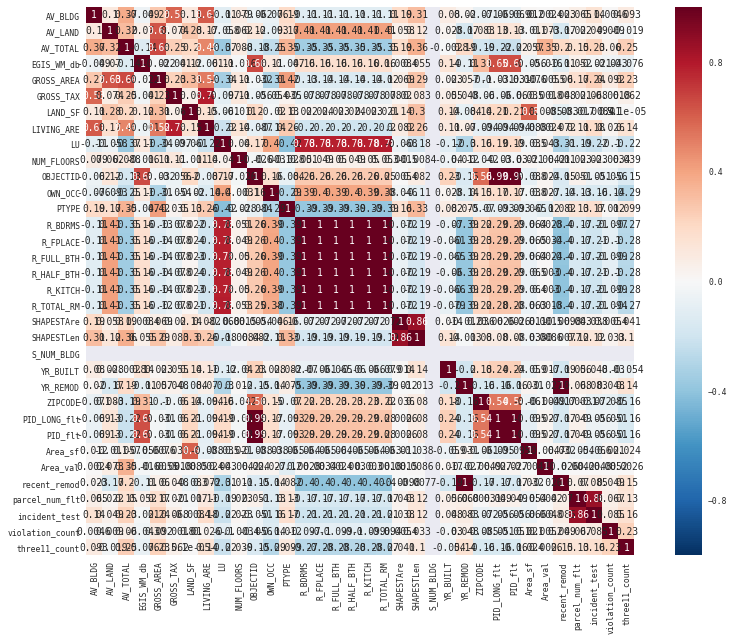

In [36]:
#### Let's take a look at the correlation matrix 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

corrmat = test_all.corr()
# corrmat = train_all.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
f.tight_layout()

In [72]:
###### Create the training and test sets ######

### We're creating the test and training sets by mixing parcels with incidents with a subset of the parcels 
### with no incidents.  For the training set, we're using 10x the number of incidents for the non-incident parcels. 
### For the test set, we're using 200x the number of incidents, as we only have three months out of the year, and 
### while the test set has 20x more months. 
### We can play with this ratio, which will change the AUC and accuracy.  The AUC will go down when we increase the 
### training sample, while the accuracy will increase. 
train_sampleN = train_all[train_all['incident_train']>0].shape[0]
test_sampleN =  test_all[test_all['incident_test']>0].shape[0]

incidents_train = train_all[train_all['incident_train']>0].index
nonincidents_train = train_all[train_all['incident_train']==0].sample(n=train_sampleN*10).index

incidents_test = test_all[test_all['incident_test']>0].index
nonincidents_test= test_all[test_all['incident_test']==0].sample(n=test_sampleN*200).index

train = pd.concat([train_all[train_all.index.isin(incidents_train)==True],\
                   train_all[train_all.index.isin(nonincidents_train)==True]])

test = pd.concat([test_all[test_all.index.isin(incidents_test)==True],\
                   test_all[test_all.index.isin(nonincidents_test)==True]])



y_train = train['incident_train'].values
y_test =  test['incident_test'].values

X_train = train.ix[:,['R_KITCH','AV_LAND','AV_BLDG','AV_TOTAL','Area_sf','Area_val','YR_BUILT','violation_count','three11_count','LU','NUM_FLOORS','OWN_OCC','GROSS_AREA','ZIPCODE']].astype(float).values
X_test = test.ix[:,['R_KITCH','AV_LAND','AV_BLDG','AV_TOTAL','Area_sf','Area_val','YR_BUILT','violation_count','three11_count','LU','NUM_FLOORS','OWN_OCC','GROSS_AREA','ZIPCODE']].astype(float).values




In [79]:
###### Random forest classifier ######
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import time



## Use cross validation to find an optimal number of classifiers
for i in np.arange(10,150,10):
    start = time.time()


    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    score = metrics.accuracy_score(y_test, y_pred)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    score = np.mean(cross_val_score(clf, X_test, y_test,scoring ='accuracy',cv=4))
                    
    model_auc = np.mean(cross_val_score(clf, X_test, y_test,scoring ='roc_auc',cv=4))
            
    print ('Number of trees are %s'%i)
#     print ('Mean AUC \t',np.mean(cross_val_score(clf, X_test, y_test,scoring ='roc_auc',cv=4)))
    print ('AUC is %s'%model_auc,'\t Accuracy is %s'%score)
    end = time.time()
    print ('Runtime is %s'%(end - start))
## Using around 100-120 trees seem best here, which gets us around 0.62 AUC and a 0.99 accuracy. However, 
## Increasing the number of trees also increasese the run-time by quite a bit. 


Number of trees are 10
AUC is 0.561100661394 	 Accuracy is 0.992170872028
Runtime is 3.579084873199463
Number of trees are 20
AUC is 0.560940066256 	 Accuracy is 0.985336922519
Runtime is 7.006759881973267
Number of trees are 30
AUC is 0.573313404022 	 Accuracy is 0.973528153046
Runtime is 11.103445053100586
Number of trees are 40
AUC is 0.591338022583 	 Accuracy is 0.986489040133
Runtime is 14.841809749603271
Number of trees are 50
AUC is 0.599013047079 	 Accuracy is 0.982770989481
Runtime is 18.21086287498474
Number of trees are 60
AUC is 0.599197111795 	 Accuracy is 0.990914061577
Runtime is 22.196224689483643
Number of trees are 70
AUC is 0.595928115668 	 Accuracy is 0.993794254136
Runtime is 25.60209894180298
Number of trees are 80
AUC is 0.611320729517 	 Accuracy is 0.991830486607
Runtime is 28.458886861801147
Number of trees are 90
AUC is 0.604292605683 	 Accuracy is 0.990626045886
Runtime is 31.324420928955078
Number of trees are 100
AUC is 0.61316747737 	 Accuracy is 0.9924327

### Results for Random Forest classifiers
Using around 80-120 trees seem best here, which gets us around 0.61 AUC and a 0.99 accuracy. However, increasing the number of trees also increasese the run-time by quite a bit. 



In [81]:
from sklearn.ensemble import GradientBoostingClassifier

for i in np.arange(.1,.9,.05):
    start = time.time()


    clf=GradientBoostingClassifier(learning_rate=i,n_estimators=int(100*(1+i)))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    score = np.mean(cross_val_score(clf, X_test, y_test,scoring ='accuracy',cv=4))
                    
    model_auc = np.mean(cross_val_score(clf, X_test, y_test,scoring ='roc_auc',cv=4))
            

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print ('learning rate is %s'%i,'\t AUC is %s'%model_auc,'\t Accuracy is %s'%score)
    end =  time.time()
    print ('Runtime is %s'%(end - start))


learning rate is 0.1 	 AUC is 0.686639026922 	 Accuracy is 0.891957941284
Runtime is 21.089849710464478
learning rate is 0.15 	 AUC is 0.693736637971 	 Accuracy is 0.928911487624
Runtime is 23.61993980407715
learning rate is 0.2 	 AUC is 0.634074934677 	 Accuracy is 0.933624393114
Runtime is 25.314812898635864
learning rate is 0.25 	 AUC is 0.620524595231 	 Accuracy is 0.857290726553
Runtime is 26.039467096328735
learning rate is 0.3 	 AUC is 0.667528112169 	 Accuracy is 0.984839430649
Runtime is 27.768565893173218
learning rate is 0.35 	 AUC is 0.67979029022 	 Accuracy is 0.977036790598
Runtime is 29.458000898361206
learning rate is 0.4 	 AUC is 0.687259716779 	 Accuracy is 0.924931626716
Runtime is 28.532164096832275
learning rate is 0.45 	 AUC is 0.572584908081 	 Accuracy is 0.816418298021
Runtime is 28.686460971832275
learning rate is 0.5 	 AUC is 0.623950109649 	 Accuracy is 0.798849247646
Runtime is 27.56224274635315
learning rate is 0.55 	 AUC is 0.659882955394 	 Accuracy is 0.8

### Results for Gradient Boosted Forests
Using a learning rate of 0.35-0.4 gets us between 0.68 - 0.69 AUC and a 0.97 - 0.92 accuracy, which seems like it's a slightly better classifier to use here. And it's also significantly faster.



In [52]:

importances = clf.feature_importances_
print (importances)


array([ 0.01148088,  0.10077047,  0.13096275,  0.11909563,  0.10504407,
        0.11334627,  0.06374814,  0.02048676,  0.07062921,  0.03792339,
        0.0344669 ,  0.01018129,  0.11970629,  0.06215795])